In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sparse_shift.plotting import plot_dag
import pickle

## DAGs in triangle MEC

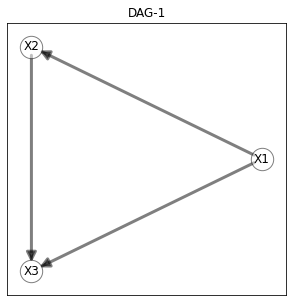

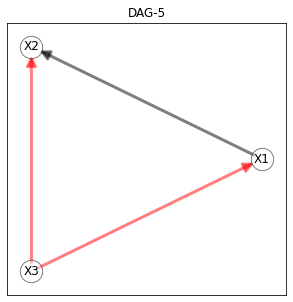

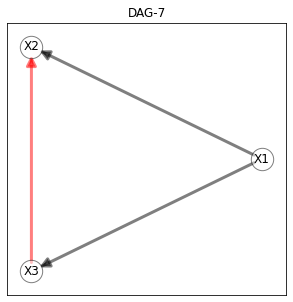

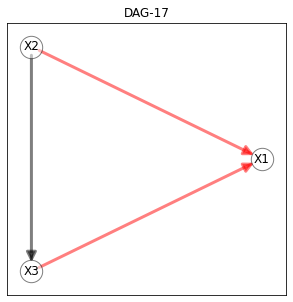

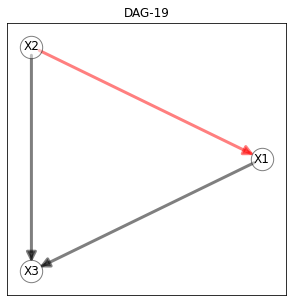

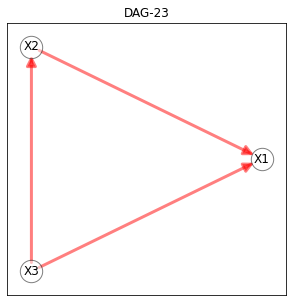

In [5]:
with open("./dag_dict_all_triangles.pkl", "rb") as f:
    dag_dict = pickle.load(f)

# Restrict to MEC
dag_dict = {
    key: dag for key, dag in dag_dict.items() if np.sum(dag) == 3
}

true_parents = dag_dict['DAG-1']
true_dag = 'DAG-1'

for key, dag in dag_dict.items():
    plot_dag(
        dag,
        highlight_edges=dag-true_parents,
        title=key)

In [35]:
def create_metrics_df(raw_df, true_dag_key):
    df = raw_df.copy()
    
    n_features = 1
    while f'X{n_features}' in df.columns:
        n_features += 1
    n_features -= 1

    alpha = 0.05 / n_features
    dag_keys = df['dag'].unique()

    # convert from pvalues to n_changes at alpha
    df['total_changes'] = 0
    for i in range(1, n_features+1):
        df[f'X{i}'] = df[f'X{i}'] <= alpha
        df['total_changes'] += df[f'X{i}']
    
    # group by everything except dag, and variables
    # +2 for reps and total_changes
    group_cols = list(df.columns[:-(n_features+2)]) 
    df = pd.pivot_table(df, index=group_cols,
        values='total_changes',
        columns='dag').reset_index()

    # within each rep, compute:
    # - min changes
    # - true dag in min set
    # - size of min set
    
    df['min_changes'] = df[dag_keys].min(1)
    df['true_in_min_set'] = df[true_dag_key] == df['min_changes']
    df['min_set_size'] = np.sum([df[key] == df['min_changes'] for key in dag_keys], 0)
    df['frac_mec_resolved'] = 1 - df['min_set_size'] / len(dag_keys)
    
    df['true_identified'] = df['true_in_min_set'] & (df['min_set_size'] == 1)
    df['false_identified'] = 1 - df['true_in_min_set']
    df['undetermined'] = df['true_in_min_set'] & (df['min_set_size'] > 1)
    
    return df.groupby(group_cols[:-1]).mean().reset_index()

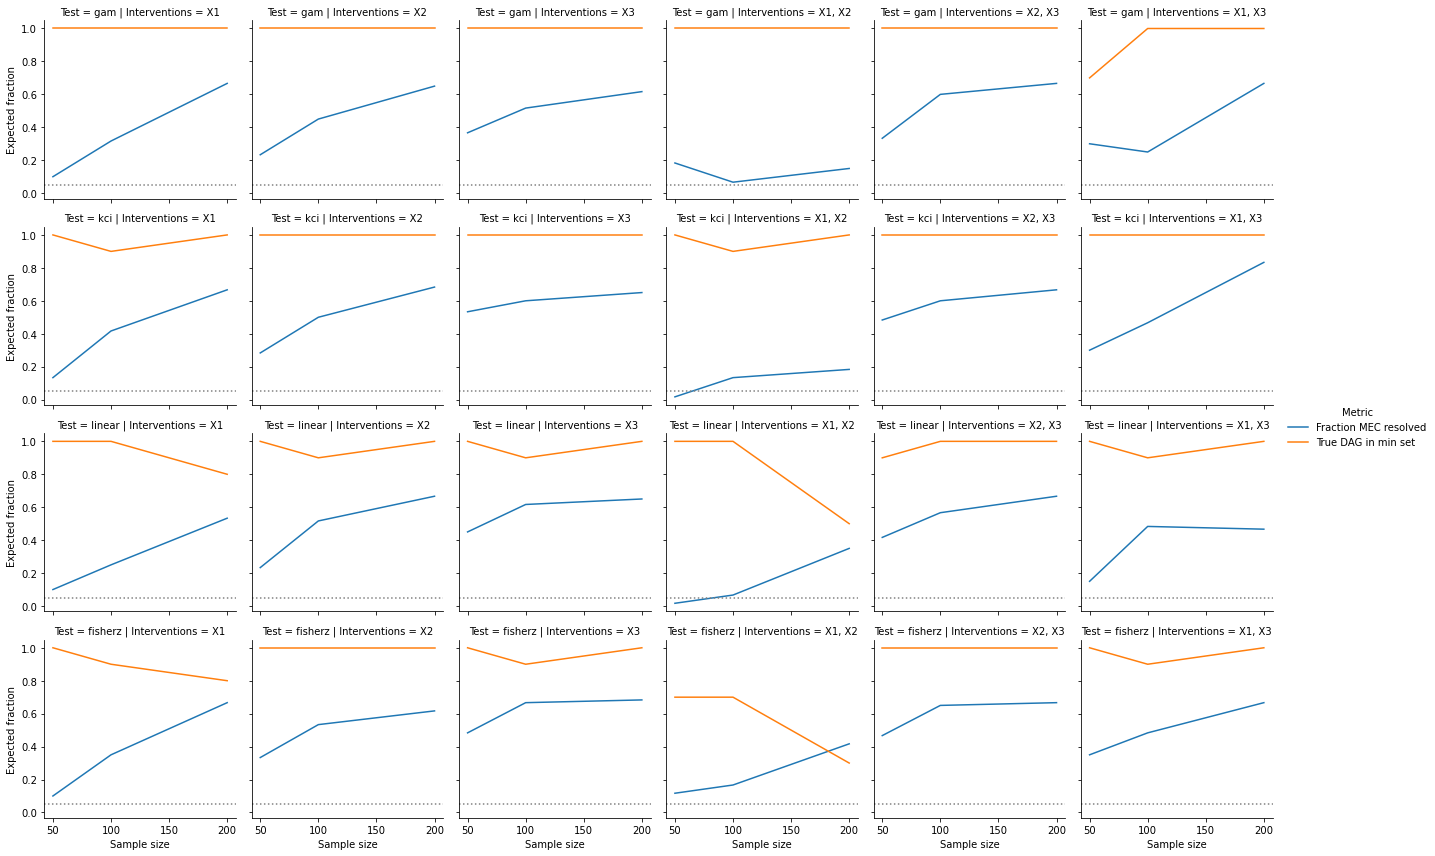

In [43]:
df = pd.read_csv('./triangle_icp_pvalues.csv', delimiter=', ', engine='python')
metrics_df = create_metrics_df(df, true_dag_key='DAG-1')

metrics_df['test'] = metrics_df['test'] + ' (' + metrics_df['test_kwargs'] + ')'



plot_df.replace(
    {
        "invariant_residuals ({'method': 'gam','test': 'ks'})": 'gam',
        "invariant_residuals ({'method': 'linear','test': 'ks'})": 'linear',
        "kci ({})": "kci",
        "fisherz ({})": 'fisherz',
        "[None,0]": 'X1',
        "[None,1]": 'X2',
        "[None,2]": 'X3',
        "[None,(0,1)]": 'X1, X2',
        "[None,(1,2)]": 'X2, X3',
        "[None,(0,2)]": 'X1, X3',
        "true_identified": "True DAG identified",
        "false_identified": "False DAGs identified",
        "undetermined": "Undetermined",
        'frac_mec_resolved': 'Fraction MEC resolved',
        'true_in_min_set': 'True DAG in min set',
    }, inplace=True
)

plot_df.rename(
    {
        "test": "Test",
        "n_samples": "Sample size",
        "expected_fraction": "Expected fraction",
        "intervention_targets": "Interventions",
        "metric": "Metric",
    }, axis=1, inplace=True
)

g = sns.relplot(
    data=plot_df,
    x='Sample size',
    y='Expected fraction',
    col='Interventions',
    row='Test',
    hue='Metric',
    kind='line',
    height=3, aspect=1,
    legend='full',
    row_order=['gam', 'kci', 'linear', 'fisherz']
)

for ax in g.axes.flatten():
    ax.axhline(0.05, ls=':', c='grey')

plt.show()